# Dependencies

In [1]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install transformers
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Fri Jun 30 13:56:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [3]:
import torch
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, get_scheduler, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset

# Constants

In [4]:
from google.colab import drive
GOOGLE_DRIVE_BASE_DIR = "/content/drive/MyDrive/TPs/Quinto/NLP"
drive.mount("/content/drive")

Mounted at /content/drive


# Trump tweets generation

In [5]:
trump_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/trump_tweets.txt"
biden_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/biden_tweets.txt"

In [6]:
# biden = open(biden_file_path, encoding="UTF-8").read().splitlines()
trump = open(trump_file_path, encoding="UTF-8").read().splitlines()

seed = 40

train_data, test_data = train_test_split(trump, test_size=0.3, random_state=seed)

test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Initialize the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.add_special_tokens({
  "eos_token": "</s>",
  "bos_token": "<s>",
  "unk_token": "<unk>",
  "pad_token":  tokenizer.eos_token,
  "mask_token": "<mask>"
})

train_tokenized = tokenizer(train_data, padding="max_length", truncation=True, max_length=128)
val_tokenized = tokenizer(val_data, padding="max_length", truncation=True, max_length=128)
test_tokenized = tokenizer(test_data, padding="max_length", truncation=True, max_length=128)

class TweetDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, index):
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


train_dataset = TweetDataset(train_tokenized)
val_dataset = TweetDataset(val_tokenized)
test_dataset = TweetDataset(test_tokenized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

max_epochs = 10

# Filtered trump tweets: 879
# Filtered biden tweets: 439

In [7]:
def train_model(model, max_epochs, optimizer, scheduler, layers_freezed):
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["input_ids"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        loss_map[f'freezed_{layers_freezed}'].append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss}")

        # Evaluate on the validation set
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = input_ids.clone().detach()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        print(f"Epoch {epoch + 1}: Average validation loss = {avg_eval_loss}")

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = input_ids.clone().detach()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test loss: {avg_test_loss}")

    return model

In [41]:
loss_map = {}
models = []

device = f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"

layers_to_freeze = [0, 4, 8, 12]
for freeze in layers_to_freeze:
  loss_map[f"freezed_{freeze}"] = []

  model = GPT2LMHeadModel.from_pretrained('gpt2')
  model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
  scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=max_epochs * len(train_loader))

  print(f"### Freezing {freeze} Layers ###")
  for i in range(freeze):
    for param in model.transformer.h[i].parameters():
      param.requires_grad = False

  print("### Training ###")
  models.append(train_model(model, max_epochs, optimizer, scheduler, freeze))

### Freezing 9 Layers ###
### Training ###
Epoch 1: Average training loss = 6.820473575592041
Epoch 1: Average validation loss = 6.348326301574707
Epoch 2: Average training loss = 4.481503820419311
Epoch 2: Average validation loss = 4.267343997955322
Epoch 3: Average training loss = 2.89572696685791
Epoch 3: Average validation loss = 2.83370304107666
Epoch 4: Average training loss = 2.079654687643051
Epoch 4: Average validation loss = 2.189888620376587
Epoch 5: Average training loss = 1.7872448921203614
Epoch 5: Average validation loss = 1.967165732383728
Epoch 6: Average training loss = 1.6940487682819367
Epoch 6: Average validation loss = 1.8786465883255006
Epoch 7: Average training loss = 1.6534099459648133
Epoch 7: Average validation loss = 1.8351746320724487
Epoch 8: Average training loss = 1.644895476102829
Epoch 8: Average validation loss = 1.8112034797668457
Epoch 9: Average training loss = 1.611574512720108
Epoch 9: Average validation loss = 1.7986532688140868
Epoch 10: Averag

In [9]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

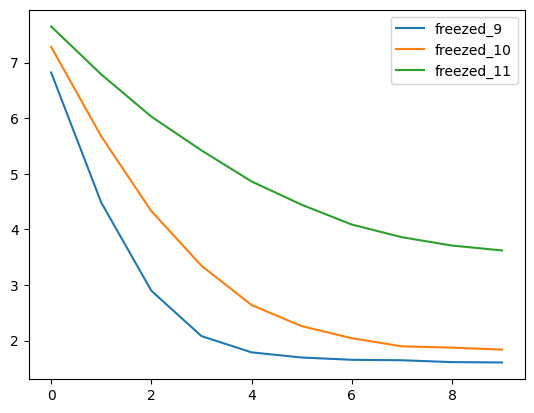

In [42]:
for k, v in loss_map.items():
  plt.plot(v, label = k)

plt.legend()
plt.show()

In [44]:
prompt = "Trump is"
max_length = 140
models[0].eval()
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

output = models[0].generate(
    input_ids=input_ids,
    do_sample=True,
    num_return_sequences=4,
    temperature=0.9,
    max_length=max_length,
    top_k=50,
    top_p=0.95,
)

generated_tweets = [tokenizer.decode(tweet, skip_special_tokens=True) for tweet in output]

# Print generated tweets
for tweet in generated_tweets:
    print(tweet)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Trump is a liar, a cheat, a fraud and is lying to the American people about the role he plays in his life," said Mr Trump.
Trump is a man who has a history of sexual harassment and assault on the part of women and men. He's a man who would rather have his daughters be sexually assaulted by a stranger than his own daughters. He was a man who would rather have women having a choice between them and him than having his daughters be sexually assaulted by another person. He didn't do it because his daughters didn't deserve it, but because his daughters didn't deserve to be sexually assaulted by his own daughters.
Trump is not only ignorant but also incompetent

The fact that he thinks he can win the presidency is the most obvious sign that he has not learned from past mistakes in his career.
Trump is still in his early days and has been trying to make up for a disappointing performance with a series of recent scandals and scandals. He's still looking to change his message and position on th

In [12]:
# gpt2.copy_checkpoint_to_gdrive(run_name='trump_tweets')

In [13]:
# generated_trump_tweets = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                                        return_as_list=True, run_name='trump_tweets',
#                                        prefix="Generate a list of tweets.\n")
#
# for tweet in generated_trump_tweets:
#     print(tweet + '\n\n')

## Run from checkpoint

In [14]:
# gpt2.copy_checkpoint_from_gdrive(run_name='trump_tweets')

In [15]:
# sess = gpt2.start_tf_sess()

In [16]:
# gpt2.load_gpt2(sess, run_name='trump_tweets')

In [17]:
# generated_trump_tweets = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                                        return_as_list=True, run_name='trump_tweets',
#                                        prefix="Generate a list of tweets.\n")
#
# for tweet in generated_trump_tweets:
#     print(tweet + '\n\n')

# Biden tweets generation

In [18]:
# biden_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/biden_tweets.txt"

In [19]:
# sess = gpt2.start_tf_sess()
#
# gpt2.finetune(sess, dataset=biden_file_path, model_name='124M', steps=1000, restore_from='fresh',
#               run_name='biden_tweets',
#               print_every=10, sample_every=200, save_every=500)

In [20]:
# gpt2.copy_checkpoint_to_gdrive(run_name='biden_tweets')

In [21]:
# generated_biden_tweets = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                                        return_as_list=True, run_name='biden_tweets',
#                                        prefix="Generate a list of tweets.\n")
#
# for tweet in generated_biden_tweets:
#     print(tweet + '\n\n')

## Run from checkpoint

In [22]:
# gpt2.copy_checkpoint_from_gdrive(run_name='biden_tweets')

In [23]:
# sess = gpt2.start_tf_sess()

In [24]:
# gpt2.load_gpt2(sess, run_name='biden_tweets')

In [25]:
# generated_biden_tweets = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                                        return_as_list=True, run_name='biden_tweets',
#                                        prefix="Generate a list of tweets.\n")
#
# for tweet in generated_biden_tweets:
#     print(tweet + '\n\n')

# Users generation

In [26]:
# users_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/users.txt"

In [27]:
# sess = gpt2.start_tf_sess()
#
# gpt2.finetune(sess, dataset=users_file_path, model_name='124M', steps=1000, restore_from='fresh', run_name='users',
#               print_every=10, sample_every=200, save_every=500)

In [28]:
# gpt2.copy_checkpoint_to_gdrive(run_name='users')

In [29]:
# users = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                       return_as_list=True, run_name='users',
#                       prefix="Generate a list of usernames and descriptions.\n")
#
# for user in users:
#     print(user + '\n\n')

## Run from checkpoint

In [30]:
# gpt2.copy_checkpoint_from_gdrive(run_name='users')

In [31]:
# sess = gpt2.start_tf_sess()

In [32]:
# gpt2.load_gpt2(sess, run_name='users'),

In [33]:
# users = gpt2.generate(sess, length=256, temperature=0.7, nsamples=5, batch_size=5,
#                       return_as_list=True, run_name='users',
#                       prefix="Generate a list of usernames and descriptions.\n")
#
# for user in users:
#     print(user + '\n\n')